#Grad-CAM: VISUALIZACIÓN

#1. PREPARACIÓN DE LOS DATOS

In [ ]:
## CARGA DE DATOS (image*segmentation)
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_segmentation.rar'

In [ ]:
## CARGA DE DATOS (Undersampling)
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/Segmentacion/'
train_dir = 'dataset_segmentation/train'
test_dir  = 'dataset_segmentation/test'

In [ ]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Model, load_model
from tensorflow.keras.layers    import Input

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image, ImageOps
import shutil
import os

from IPython.display import Image, display
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprimimos en pantalla el resultado de todos los statements

#2. PREPARACIÓN DEL MODELO

In [ ]:
## FUNCIÓN DE CONVERSIÓN DE IMÁGENES
## ======================================

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    img = img.convert('L')
    img = keras.preprocessing.image.img_to_array(img)/255.
    array = np.expand_dims(img, axis=0)
    return array

In [ ]:
## MODELO
## ======================================================

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
          for layer in reversed(self.model.layers):
              # check to see if the layer has a 4D output
              if len(layer.output_shape) == 4:
                  return layer.name
          raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
          gradModel = Model(
              inputs=[self.model.inputs],
              outputs=[self.model.get_layer(self.layerName).output,
                  self.model.output])
  # record operations for automatic differentiation
          with tf.GradientTape() as tape:
              inputs = tf.cast(image, tf.float32)
              (convOutputs, predictions) = gradModel(inputs)
              loss = predictions[:, self.classIdx]
  # use automatic differentiation to compute the gradients
          grads = tape.gradient(loss, convOutputs)
  # compute the guided gradients
          castConvOutputs = tf.cast(convOutputs > 0, "float32")
          castGrads = tf.cast(grads > 0, "float32")
          guidedGrads = castConvOutputs * castGrads * grads
          convOutputs = convOutputs[0]
          guidedGrads = guidedGrads[0]
          weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
          cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  # resize the heatmap to oringnal X-Ray image size
          (w, h) = (image.shape[2], image.shape[1])
          heatmap = cv2.resize(cam.numpy(), (w, h))
  # normalize the heatmap
          numer = heatmap - np.min(heatmap)
          denom = (heatmap.max() - heatmap.min()) + eps
          heatmap = numer / denom
          heatmap = (heatmap *255).astype("uint8")
  # return the resulting heatmap to the calling function
          return heatmap

In [ ]:
## CARGA DE MODELOS
## =============================================================================

model     = load_model('drive/MyDrive/TFM/UnderSampling-Dataset/Convolutional-Regular/' + 'Convolutional-Regularmodel.h5')
model_seg = load_model('drive/MyDrive/TFM/Segmentation/' + 'Conv-Regularsegmentation.h5')

In [ ]:
## ÚLTIMA CAPA CONVOLUCIONAL
## =============================================================================

last_conv_layer_name = 'conv2d_6'

In [ ]:
## CATEGORIAS
## =============================================================================

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

#3. CARGA DE IMÁGENES

In [ ]:
## DIRECTORIOS (Modelo Convolucional 1 sin y con segmentación)
## =========================================================================

index = 145

# Originales
images_original   = os.listdir('dataset_undersampling/train/Viral_Pneumonia/')
img_path_original = os.path.join('dataset_undersampling/train/Viral_Pneumonia/', images_original[index])

# Segmentación
images_seg = os.listdir('dataset_segmentation/train/Viral_Pneumonia/')
img_path_seg = os.path.join('dataset_segmentation/train/Viral_Pneumonia/', images_seg[index])

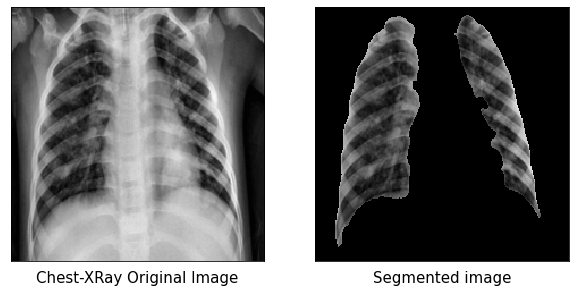

In [ ]:
## VISUALIZACIÓN (Modelo Convolucional 1 sin y con segmentación)
## ============================================================================

plt.figure(1, figsize=(10, 10))
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.xlabel('Chest-XRay Original Image', labelpad=10, fontsize=15)
original = cv2.imread(img_path_original)
plt.imshow(original, interpolation='nearest')

plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.xlabel('Segmented image', labelpad=10, fontsize=15)
seg = cv2.imread(img_path_seg)
plt.imshow(seg, interpolation='nearest');

#3. Grad-CAM: SIN SEGMENTACIÓN

In [ ]:
## PREPRACIÓN DE LA IMAGEN
## =============================================================================

img_original = get_img_array(img_path_original, size=(224,224))
img_original.shape

(1, 224, 224, 1)

In [ ]:
## PREDICCIÓN DE LA IMAGEN
## =============================================================================

preds = model.predict(img_original)
i = np.argmax(preds[0])
print(i, preds, class_names[i])

3 [[9.2231940e-06 7.5383150e-07 4.4498443e-06 9.9998558e-01]] Viral_Pneumonia


In [ ]:
## CREACIÓN DE HEATMAP
## =============================================================================

cam = GradCAM(model=model, classIdx=i, layerName=last_conv_layer_name) # find the last 4d shape "mixed10" in this case
heatmap = cam.compute_heatmap(img_original)

In [ ]:
## SUPERPOSICIÓN DE IMÁGENES
## =============================================================================

heatmap    = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
heatmap    = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)               # COLORMAP_JET, COLORMAP_VIRIDIS, COLORMAP_HOT
image_heat = cv2.addWeighted(heatmap, 0.5, original, 1, 0)

#4. Grad-CAM: CON SEGMENTACIÓN

In [ ]:
## PREPRACIÓN DE LA IMAGEN
## =============================================================================


img_seg = get_img_array(img_path_seg, size=(224,224))
img_seg.shape

(1, 224, 224, 1)

In [ ]:
## PREDICCIÓN DE LA IMAGEN
## =============================================================================

preds = model_seg.predict(img_seg)
i = np.argmax(preds[0])
print(i, preds, class_names[i])

3 [[2.6617799e-06 1.1401316e-07 3.5139669e-03 9.9648321e-01]] Viral_Pneumonia


In [ ]:
## CREACIÓN DE HEATMAP
## =============================================================================

cam_seg = GradCAM(model=model_seg, classIdx=i, layerName=last_conv_layer_name) # find the last 4d shape "mixed10" in this case
heatmap_seg = cam_seg.compute_heatmap(img_seg)

In [ ]:
## SUPERPOSICIÓN DE IMÁGENES
## =============================================================================

heatmap_seg    = cv2.resize(heatmap_seg, (seg.shape[1], seg.shape[0]))
heatmap_seg    = cv2.applyColorMap(heatmap_seg, cv2.COLORMAP_HOT)               # COLORMAP_JET, COLORMAP_VIRIDIS, COLORMAP_HOT
image_heat_seg = cv2.addWeighted(heatmap_seg, 0.5, original, 1, 0)

#4. VISUALIZACIÓN

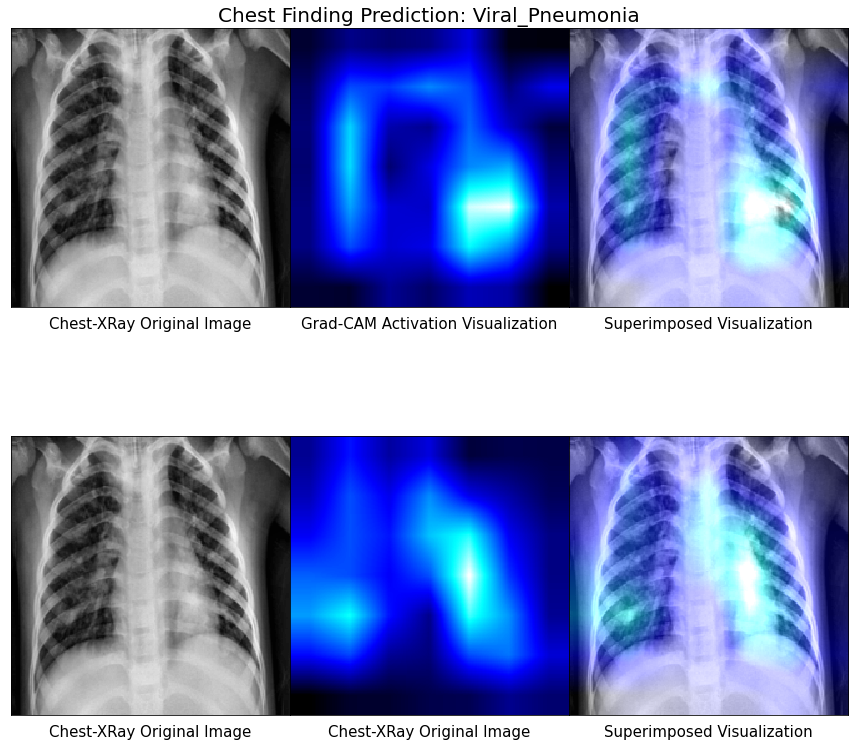

In [ ]:
## VISUALIZACIÓN Grad-CAM SIN Y CON VISUALIZACIÓN
## =============================================================================

plt.figure(1, figsize=(15, 15))
plt.subplot(231)
plt.xticks([])
plt.yticks([]) 
plt.xlabel('Chest-XRay Original Image', labelpad=10, fontsize=15)
plt.imshow(original, interpolation='nearest')

plt.subplot(232)
plt.title(f'Chest Finding Prediction: {class_names[i]}', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.xlabel('Grad-CAM Activation Visualization', labelpad=10, fontsize=15)
plt.imshow(heatmap, interpolation='nearest') 

plt.subplot(233)
plt.xticks([])
plt.yticks([])
plt.xlabel('Superimposed Visualization', labelpad=10, fontsize=15)
plt.imshow(image_heat, interpolation='nearest')


plt.subplot(234)
plt.xticks([])
plt.yticks([]) 
plt.xlabel('Chest-XRay Original Image', labelpad=10, fontsize=15)
plt.imshow(original, interpolation='nearest')

plt.subplot(235)
plt.xticks([])
plt.yticks([]) 
plt.xlabel('Chest-XRay Original Image', labelpad=10, fontsize=15)
plt.imshow(heatmap_seg, interpolation='nearest')

plt.subplot(236)
plt.xticks([])
plt.yticks([])
plt.xlabel('Superimposed Visualization', labelpad=10, fontsize=15)
plt.imshow(image_heat_seg, interpolation='nearest');

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('final.jpg');